This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 1/3rd sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/3rd sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/3rd sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [1]:
%matplotlib inline

In [2]:
#Generate the data. Will install the simdna package if necessary.
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install git+git://github.com/kundajelab/simdna.git

#This will produce a warning about embedding a TAL1_known1 motif, which is normal
!./generate_data.sh

Read in the data

In [3]:
import simdna.synthetic as synthetic
tal_gata_filename = "DensityEmbedding_prefix-talgata_motifs-GATA_disc1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
#read in the data
tal_gata_data = synthetic.read_simdata_file(tal_gata_filename)

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [4]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import MxtsMode
import keras

#load the keras model
#at the time of writing, this uses keras 0.3 and theano dimension ordering
#keras_model_weights = "record_5_model_EKIIu_modelWeights.h5"
#keras_model_yaml = "record_5_model_EKIIu_modelYaml.yaml"

keras_model_weights = "record_7_model_khP5H_modelWeights.h5"
keras_model_yaml = "record_7_model_khP5H_modelYaml.yaml"


keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml,
                                  normalise_conv_for_one_hot_encoded_input=True,
                                  name_of_conv_layer_to_normalise="conv1")

#set the reference to something with gc content of background
default = (np.ones((1,4,200))*np.array([0.27, 0.23, 0.23, 0.27])[None,:,None]).astype('float32')
#default = (np.ones((1,4,200))*np.array([0.25, 0.25, 0.25, 0.25])[None,:,None]).astype('float32')

#make various kinds of importance scoring models
deeplift_model, grad_model, guided_backprop_model,\
guided_backprop_deeplift_model, pos_through_dense_deeplift_model,\
counterbalance_dense_deeplift_model =\
    [kc.convert_graph_model(
        model=keras_model,
        mxts_mode=mxts_mode,
        default=default) for mxts_mode in [
            MxtsMode.DeepLIFT, MxtsMode.Gradient, MxtsMode.GuidedBackprop,
            MxtsMode.GuidedBackpropDeepLIFT, MxtsMode.PosThroughDenseDeepLIFT,
            MxtsMode.CounterBalanceDenseDeepLIFT]]

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
Using Theano backend.
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


One-hot encode the sequence data

In [5]:
#install the avutils package if it isn't installed
try:
    import avutils
except ImportError, e:
    print("installing avutils package")
    !pip install git+git://github.com/kundajelab/avutils.git

import avutils
import avutils.util

#get one-hot encoded sequence for the tal_gata data
tal_gata_onehot = np.array([avutils.util.seq_to_2d_image(seq) for seq in tal_gata_data.sequences])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [6]:
#make sure predictions are the same as the original model
from deeplift import backend as B
deeplift_prediction_func = B.function([deeplift_model.get_name_to_blob()['sequence'].get_activation_vars()],
                                       deeplift_model.get_name_to_blob()['output_act'].get_activation_vars())
original_model_predictions = keras_model.predict({'sequence':tal_gata_onehot}, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[tal_gata_onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions['output'])) < 10**-5
tal_gata_predictions = converted_model_predictions

Sort the predictions by confidence, for use later

In [7]:
#taldata predictions sorted by confidence
tal_gata_predictions_sorted = sorted(enumerate(tal_gata_predictions), key=lambda x: -x[1][2])

Compute the importance scores using different methods

In [8]:
#compute the importance scores on the sequences
deeplift_func, grad_times_inp_func,\
guided_backprop_func, guided_backprop_deeplift_func,\
pos_through_dense_deeplift_func, counterbalance_dense_deeplift_func =\
    [model.get_target_contribs_func(find_scores_layer_name="sequence",
                                    pre_activation_target_layer_name="output_preact")
     for model in [deeplift_model, grad_model, guided_backprop_model,
                   guided_backprop_deeplift_model, pos_through_dense_deeplift_model,
                   counterbalance_dense_deeplift_model]]

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in [('deeplift', deeplift_func),
                               ('grad_times_inp', grad_times_inp_func),
                               ('guided_backprop', guided_backprop_func),
                               ('guided_backprop_deeplift', guided_backprop_deeplift_func),
                               ('pos_through_dense_deeplift', pos_through_dense_deeplift_func),
                               ('counterbalance_dense_deeplift', counterbalance_dense_deeplift_func)]:
    method_to_task_to_scores[method_name] = {}
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[tal_gata_onehot],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        scores = np.squeeze(np.sum(scores, axis=2),axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

In [9]:
motif_locations = {'GATA_disc1':[], 'TAL1_known1':[]}
for embeddings in tal_gata_data.embeddings:
    for motif in motif_locations:
        motif_locations[motif].append([])
    for embedding in embeddings:
        motif_locations[embedding.what.getDescription()][-1]\
                       .append((embedding.startPos, embedding.startPos+len(embedding.what)))

In [10]:
def compile_scores_on_motif_locations_vs_others(scores, valid_locations,
                                                smoothen_function, batch_size=200, progress_update=None):
    scores = smoothen_function(scores, batch_size=batch_size, progress_update=progress_update)
    scores_on_valid_locations = []
    scores_on_other_locations = []
    for scores_single_region,valid_locations_single_region in zip(scores, valid_locations):
        #sort valid locations in order
        sorted_valid_locations = sorted(valid_locations_single_region, key=lambda x: x[0])
        for i in range(len(sorted_valid_locations)):
            prev_end = 0 if i==0 else sorted_valid_locations[i-1][1]
            next_start = (len(scores_single_region)
                          if i==(len(sorted_valid_locations)-1)
                          else sorted_valid_locations[i+1][0])
            scores_on_valid_locations.extend(scores_single_region[
                    sorted_valid_locations[i][0]:sorted_valid_locations[i][1]])
            scores_on_other_locations.extend(scores_single_region[prev_end:sorted_valid_locations[i][0]])
            scores_on_other_locations.extend(scores_single_region[sorted_valid_locations[i][1]:next_start])
    return scores_on_valid_locations, scores_on_other_locations

Task 0
0.917744758502
0.891098714486
0.867779889439
0.878338480145
0.901736657498
0.873734777179


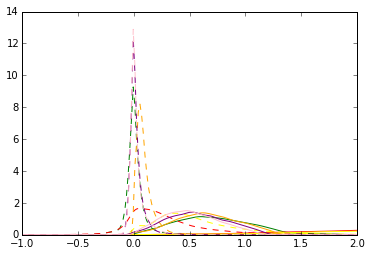

Task 1
0.838100029597
0.767265871143
0.640144765347
0.729381451137
0.781476047841
0.782187028863


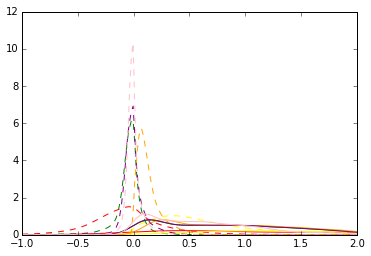

Task 2
0.568652564104
0.375760019561
0.715355767214
0.776790148225
0.802486274506
0.660016818406


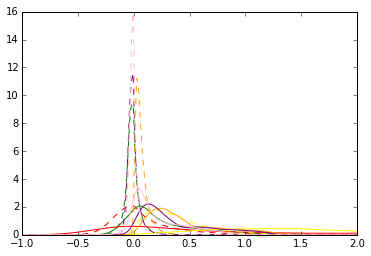

In [11]:
import matplotlib.pyplot as plt
import scipy
import deeplift.util
reload(deeplift.util)
smoothen_window = 7
smoothen_function = deeplift.util.get_smoothen_function(smoothen_window)
for task_idx, motif_locs in [(0, motif_locations['GATA_disc1']),
                                  (1, motif_locations['TAL1_known1']),
                                  (2, [x+y for x,y in zip(motif_locations['GATA_disc1'],
                                                          motif_locations['TAL1_known1'])])]:    
    print("Task "+str(task_idx))
    for method,color in [('deeplift','green'),
                         ('grad_times_inp','red'),
                         ('guided_backprop','yellow'),
                         ('guided_backprop_deeplift','orange'),
                         ('pos_through_dense_deeplift', 'purple'),
                         ('counterbalance_dense_deeplift', 'pink')]:
        scores_on_valid_locations, scores_on_other_locations =\
            compile_scores_on_motif_locations_vs_others(
                method_to_task_to_scores[method][task_idx],
                motif_locs, smoothen_function=smoothen_function)
        from scipy.stats import gaussian_kde
        min_val = min(np.min(scores_on_other_locations),np.min(scores_on_valid_locations))
        max_val = max(np.max(scores_on_other_locations),np.max(scores_on_valid_locations))
        negative_density = gaussian_kde(scores_on_other_locations)
        positive_density = gaussian_kde(scores_on_valid_locations)
        import matplotlib.pyplot as plt
        xs = np.linspace(-1, 2,200)
        plt.plot(xs,negative_density(xs),ls='dashed',color=color)
        plt.plot(xs,positive_density(xs),ls='solid',color=color)
        print(str(scipy.stats.ks_2samp(scores_on_other_locations, scores_on_valid_locations).statistic))
    plt.show()

Visualize the scores at the sequence predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

[ 0.98802304  1.          0.99915445]
6.60914
deeplift


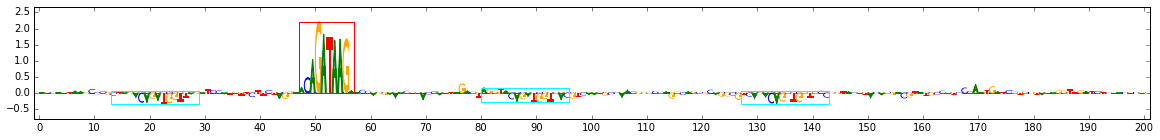

82.2308
grad_times_inp


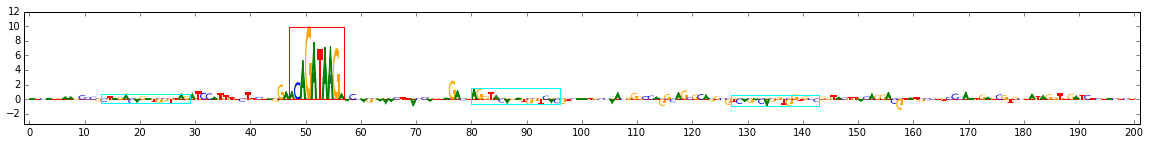

133.062
guided_backprop


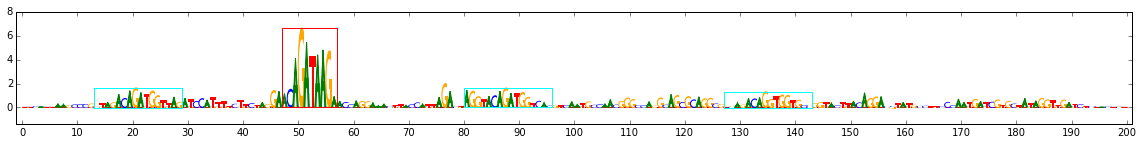

22.7262
guided_backprop_deeplift


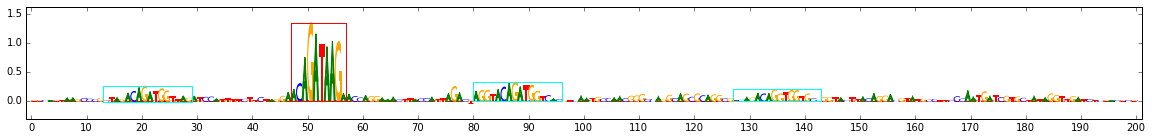

9.59269
pos_through_dense_deeplift


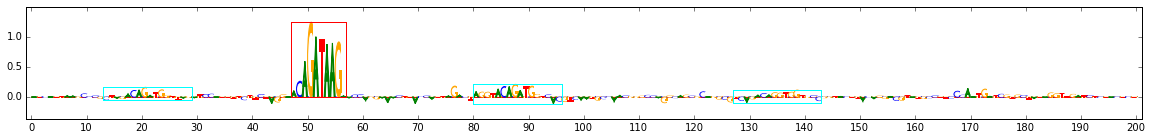

5.43671
counterbalance_dense_deeplift


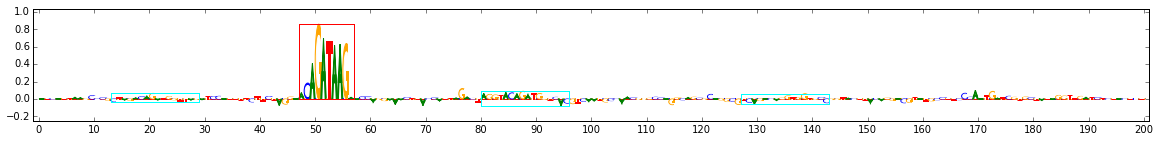

32.9733
deeplift


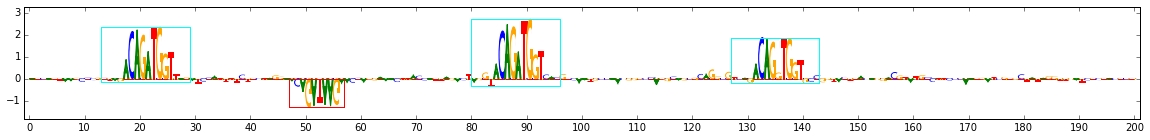

124.632
grad_times_inp


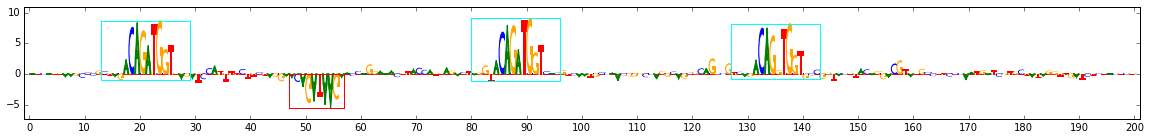

304.943
guided_backprop


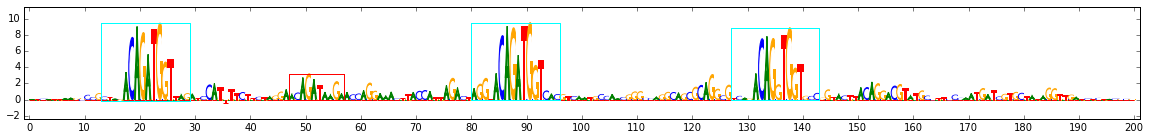

69.3747
guided_backprop_deeplift


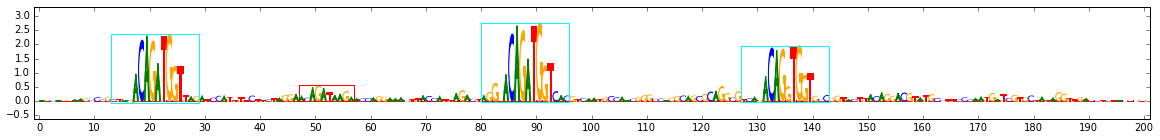

36.6868
pos_through_dense_deeplift


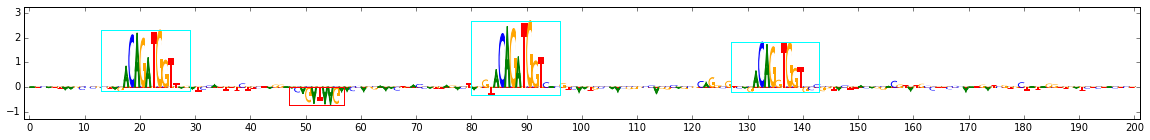

33.6902
counterbalance_dense_deeplift


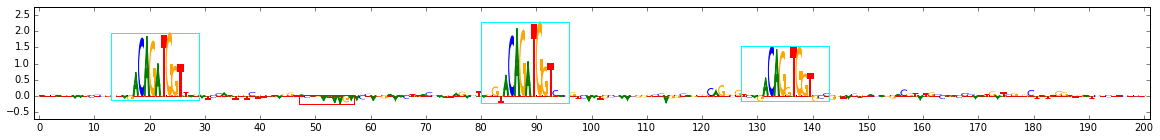

11.5523
deeplift


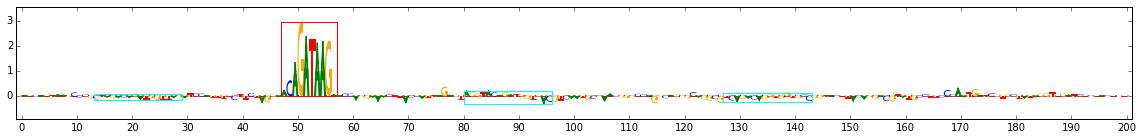

112.633
grad_times_inp


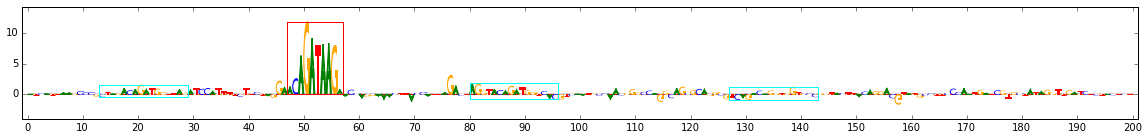

170.384
guided_backprop


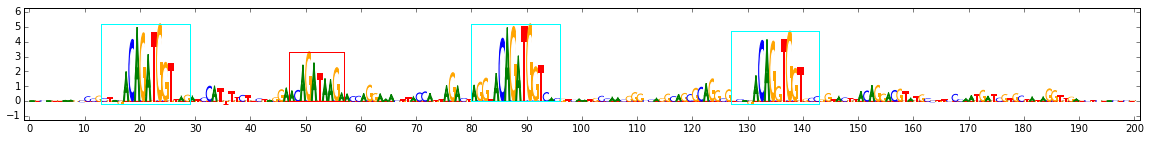

36.7948
guided_backprop_deeplift


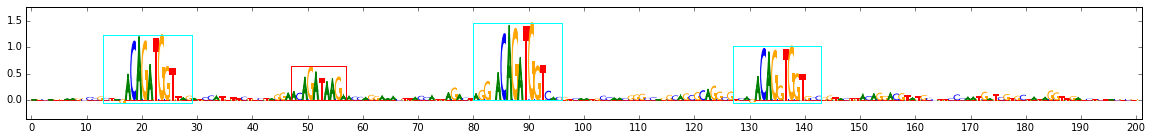

22.8668
pos_through_dense_deeplift


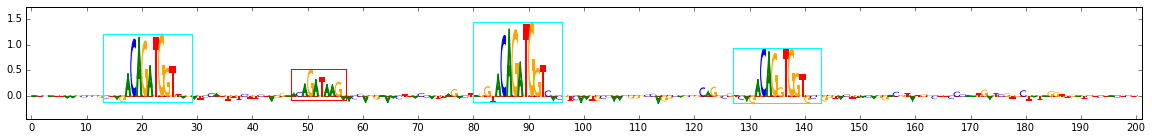

9.37648
counterbalance_dense_deeplift


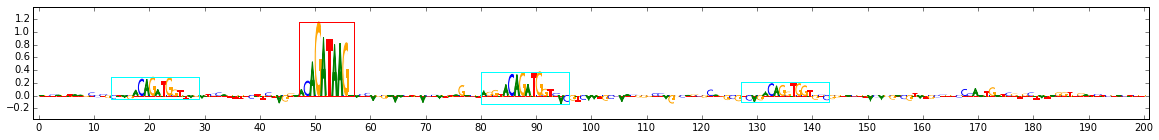

In [12]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence
reload(viz_sequence)

sorted_idx = 500
idx = tal_gata_predictions_sorted[sorted_idx][0]
conf = tal_gata_predictions_sorted[sorted_idx][1]
print(conf)

for task in [0,1,2]:
    for method_name in method_to_task_to_scores:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(np.sum(scores_for_idx))
        original_onehot = tal_gata_onehot[idx]
        scores_for_idx = original_onehot*scores_for_idx[None,None,:]
        print(method_name)
        highlight = {'red':motif_locations['GATA_disc1'][idx],
                     'cyan':motif_locations['TAL1_known1'][idx]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

Compute DeepLIFT scores on the channels

In [13]:
#Import some general util stuff
import sys, os
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils

In [14]:
sequence_data_on_positives = tal_gata_onehot

In [146]:
#compute scores of the channels
#computing deeplift scores on the conv layers
conv_layer_deeplift_contribs_func = deeplift_model.get_target_contribs_func(
    find_scores_layer_name='conv1',
    pre_activation_target_layer_name="output_preact")
filter_contribs = np.array(conv_layer_deeplift_contribs_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))

Done 0


Visualize the top-scoring channels

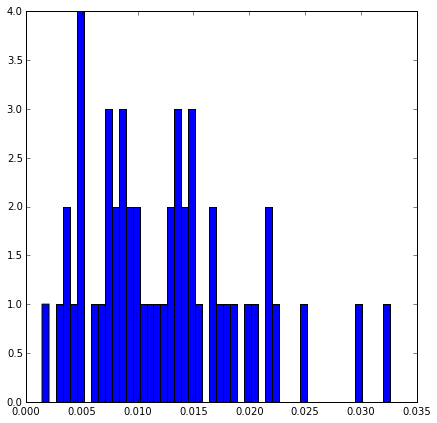

In [147]:
per_channel_scores = np.mean(np.squeeze(np.abs(filter_contribs)),axis=(-1,0))+\
                     np.mean(np.squeeze(np.abs(filter_contribs_revcomp)),axis=(-1,0))
#plot a histogram
from plottingUtilitiesPackage import matplotlibHelpers as mplh
reload(mplh)
mplh.plotHist(per_channel_scores,bins=50)

importance: 0.0326385 bias: -0.565688


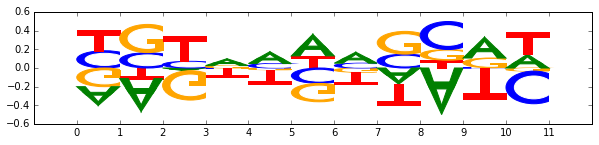

importance: 0.0298895 bias: -1.68415


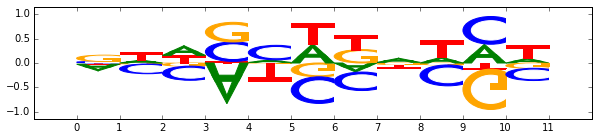

importance: 0.0251186 bias: -1.09404


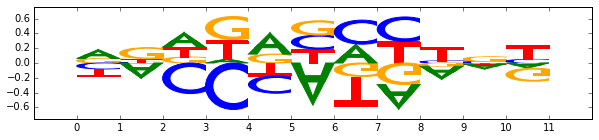

importance: 0.0222829 bias: -1.33122


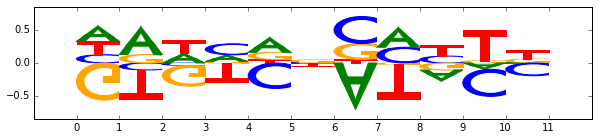

importance: 0.0216306 bias: -4.42826


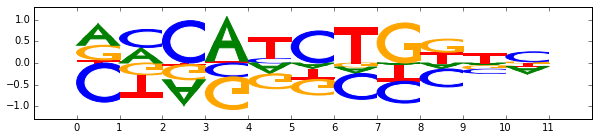

In [148]:
filter_weights, filter_biases = deeplift_model.get_name_to_blob()['conv1'].W,\
                                deeplift_model.get_name_to_blob()['conv1'].b

#sort filters by bias, plot weights
from deeplift.visualization import viz_sequence
filters_sorted_by_importance = sorted(zip(filter_weights, filter_biases, per_channel_scores), key=lambda x: -x[2])

for i in range(0,5):
    this_filter_bias = filters_sorted_by_importance[i][1]
    this_filter_weights = filters_sorted_by_importance[i][0]
    this_filter_importance = filters_sorted_by_importance[i][2]
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(np.squeeze(this_filter_weights), figsize=(10,2))

Compute the DeepLIFT scores and multipliers on the sequence

In [22]:
sequence_deeplift_contribs_func = deeplift_model.get_target_contribs_func(
    find_scores_layer_name='sequence',
    pre_activation_target_layer_name='output_preact')
sequence_contribs = np.array(
                        sequence_deeplift_contribs_func(task_idx=task_idx,
                            input_data_list=[sequence_data_on_positives],
                            batch_size=200, progress_update=1000))
sequence_contribs = np.sum(sequence_contribs,axis=-2)[:,:,None,:]*sequence_data_on_positives

#computing multipliers on sequence
sequence_deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(
                                        find_scores_layer_name='sequence',
                                        pre_activation_target_layer_name='output_preact')
sequence_multipliers = np.array(sequence_deeplift_multipliers_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))

Done 0
Done 0


Identify high-scoring segments

In [23]:
#identify the seqlets
reload(csi)
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=7,
                        flankToExpandAroundPeakSize=3,
                        excludePeaksWithinWindow=7,
                        ratioToTopPeakToInclude=0.3,
                        maxSegments=4)

seqlets, seqletIndices = csi.getSeqlets(
                                rawDeepLIFTContribs=sequence_contribs,
                                indicesToGetSeqletsOn=None,
                                revCompFunc=csi.dnaRevCompFunc,
                                outputsBeforeActivation=None, #don't worry about this
                                activation=None, #don't worry about this
                                thresholdProb=1.0, #don't worry about this
                                segmentIdentifier=segmentIdentifier,
                                numThreads=1,
                                secondsBetweenUpdates=1)

#filter out any shorter seqlets from the edges of sequences
maxSeqletLength = np.max([x.numUnderlyingObservations.shape[-1] for x in seqlets])
seqlets = [x for x in seqlets if x.numUnderlyingObservations.shape[-1] == maxSeqletLength]
seqlets_subset = seqlets[:]

Done 0 of 1000
Done 100 of 1000
Done 200 of 1000
Done 300 of 1000
Done 400 of 1000
Done 500 of 1000
Done 600 of 1000
Done 700 of 1000
Done 800 of 1000
Done 900 of 1000


In [136]:
reload(csi)
import deeplift.util as deeplift_util
reload(deeplift_util)

#augment tracks
for (dataToAugmentWith,
     name,
     pseudocount,
     fullRevCompDataArr,
     revCompFunc,
     effectiveWidth,
     effectiveStride,
     layerFromAbove) in [
       (
            #note: multiplication by 1.0 is necessary to prevent integer overflow due to int8 or whatever
            np.squeeze(sequence_data_on_positives, axis=1)*1.0, #data (raw sequence here)
            "sequence", #name
             0.25, #pseudocount
             None, #fullRevCompDataArr
             csi.dnaRevCompFunc, #revCompFunc
             1, #effectiveWidth
             1, #effectiveStride
             False #layerFromAbove
        ),
       (
            np.squeeze(sequence_multipliers, axis=1), #data
            "sequence_multipliers", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        ),
        (
            np.squeeze(sequence_contribs, axis=1), #data
            "sequence_deeplift", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        )
]:
    csi.augmentSeqletsWithData(
        seqlets_subset,
        fullDataArr=dataToAugmentWith,
        keyName=name,
        pseudocount=pseudocount,
        fullRevCompDataArr=fullRevCompDataArr,
        revCompFunc=revCompFunc,
        indicesToSubset=None,
        effectiveStride=effectiveStride,
        effectiveWidth=effectiveWidth,
        layerFromAbove=layerFromAbove,
        fillValue=0)

('idx', 0)
654


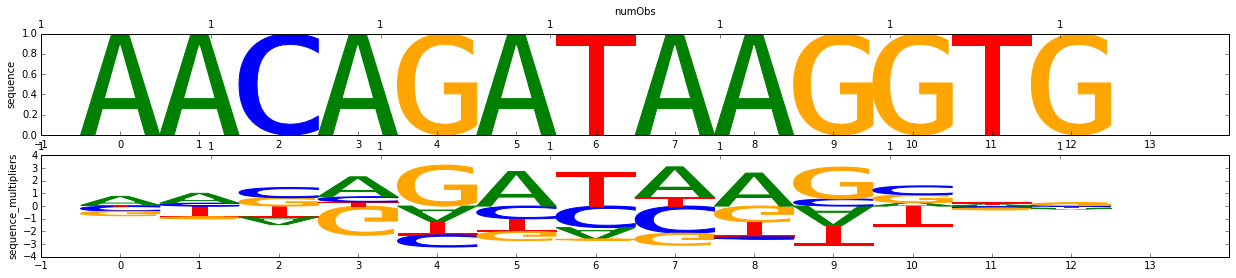

('idx', 0, 'reverse')


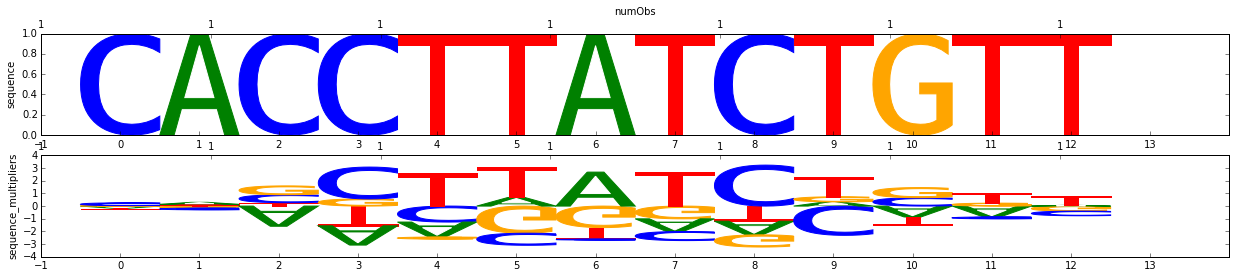

('idx', 430)
343


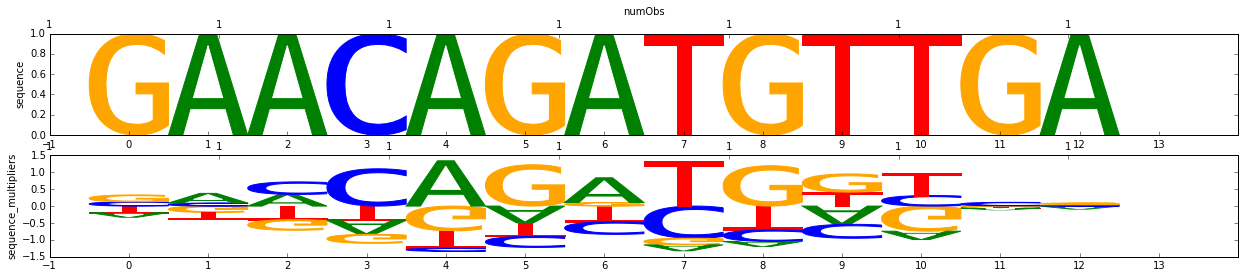

('idx', 430, 'reverse')


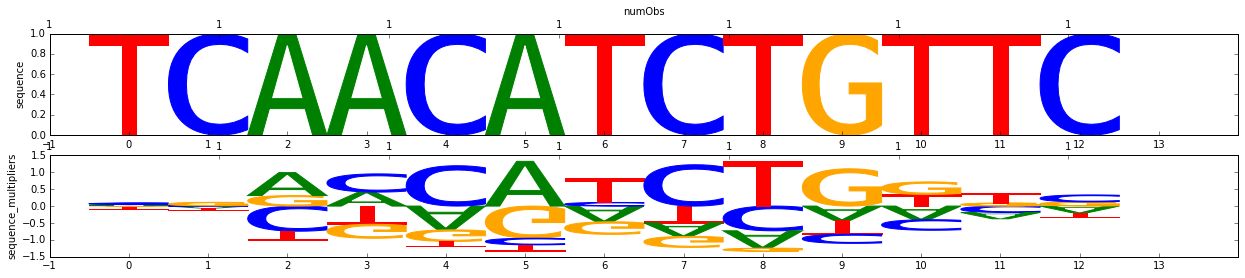

('idx', 860)
467


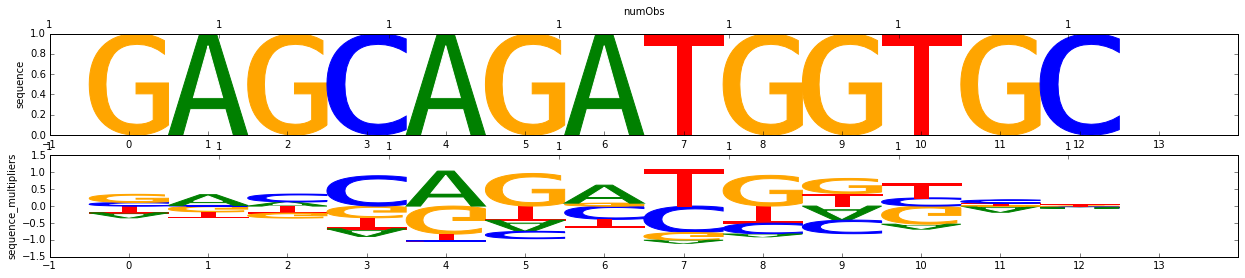

('idx', 860, 'reverse')


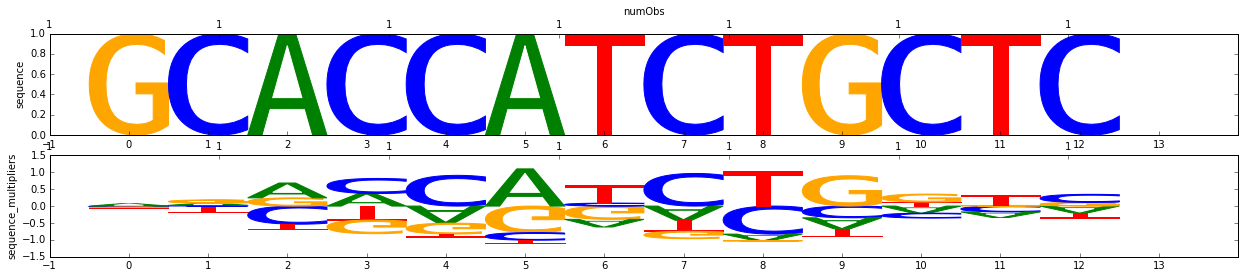

('idx', 1290)
16


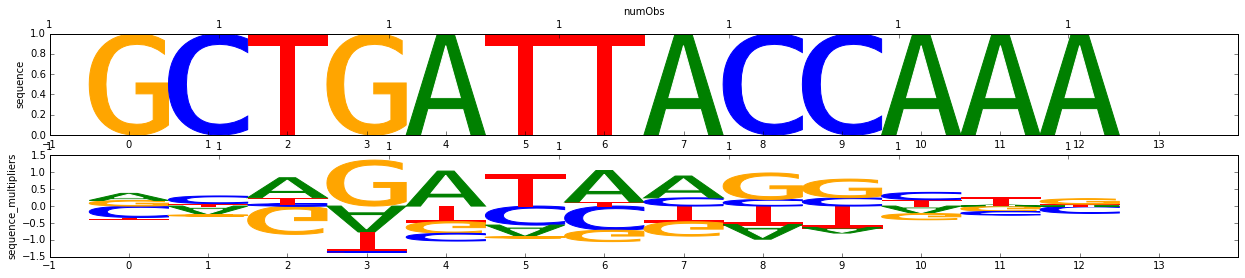

('idx', 1290, 'reverse')


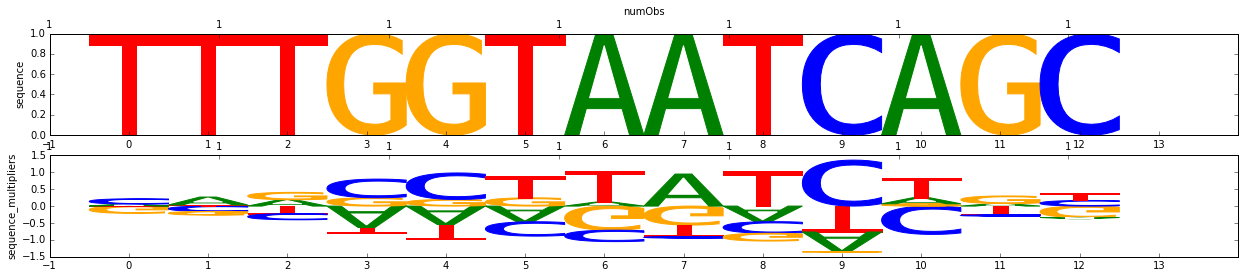

('idx', 1720)
497


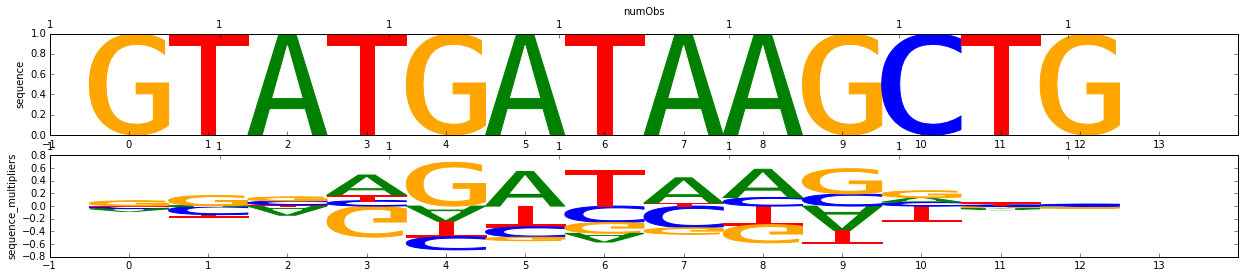

('idx', 1720, 'reverse')


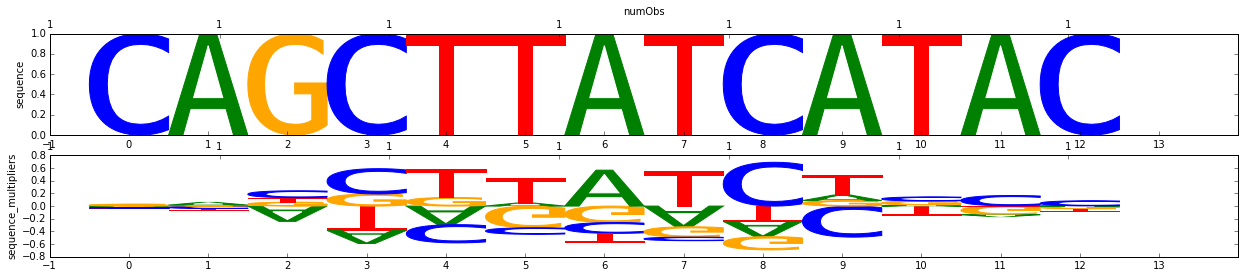

('idx', 2150)
104


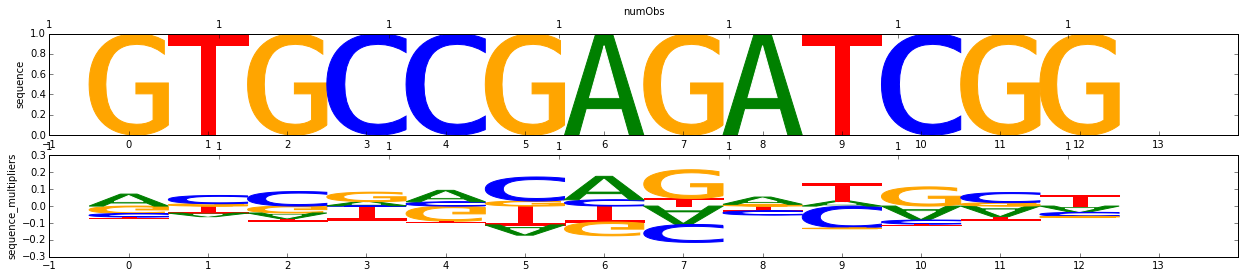

('idx', 2150, 'reverse')


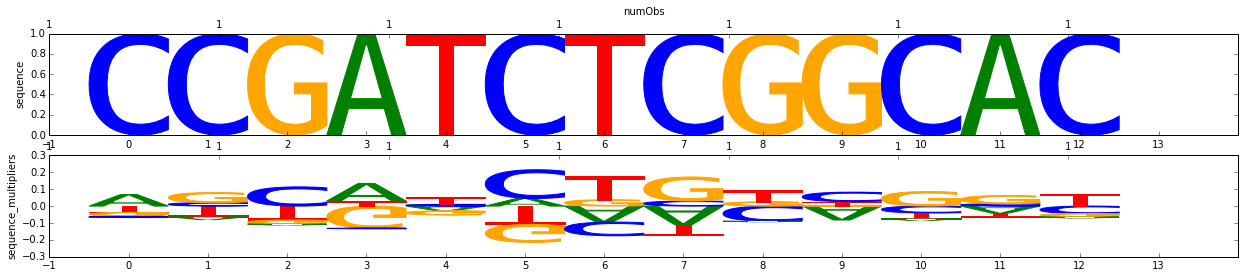

In [137]:
#visually explore some seqlets as a sanity check
reload(csi)
trackNamesToPrint=["sequence", "sequence_multipliers"]
for idx in range(0,len(seqlets_subset),len(seqlets_subset)/5):
    print("idx",idx)
    print(seqlets[idx].sequenceId)
    csi.printGrammar(seqlets[idx], trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    print("idx",idx,"reverse")
    csi.printGrammar(seqlets[idx].getRevCompGrammar(), trackNamesToPrint=trackNamesToPrint, heightPerTrack=2)

In [139]:
reload(util)
reload(csi)
seqlets_corr_mat = csi.getCorrelationMatrix(
                        seqlets_subset,
                        subtracksToInclude=["sequence_multipliers"],
                        accountForRevComp=True,
                        numThreads=None,
                        secondsBetweenUpdates=3,
                        xcorBatchSize=50)

Num words: 2151 and 2151
('On filters', 0, 'to', 19230)
Done 0
Done 1000
Done 2000
('On filters', 0, 'to', 19230)
Done 0
Done 1000
Done 2000
Seconds to compute corr mat: 31.0464131832


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2151
[t-SNE] Computed conditional probabilities for sample 2000 / 2151
[t-SNE] Computed conditional probabilities for sample 2151 / 2151
[t-SNE] Mean sigma: 0.045627
[t-SNE] Iteration 25: error = 1.3477666, gradient norm = 0.0052235
[t-SNE] Iteration 50: error = 1.2744608, gradient norm = 0.0037351
[t-SNE] Iteration 75: error = 1.1048745, gradient norm = 0.0017276
[t-SNE] Iteration 100: error = 1.0803837, gradient norm = 0.0015554
[t-SNE] Error after 100 iterations with early exaggeration: 1.080384
[t-SNE] Iteration 125: error = 1.0377492, gradient norm = 0.0013771
[t-SNE] Iteration 150: error = 1.0254358, gradient norm = 0.0013285
[t-SNE] Iteration 175: error = 1.0224148, gradient norm = 0.0013186
[t-SNE] Iteration 200: error = 1.0215839, gradient norm = 0.0013128
[t-SNE] Iteration 225: error = 1.0213730, gradient norm = 0.0013116
[t-SNE] Iteration 250: error = 1.0213050, gradient n

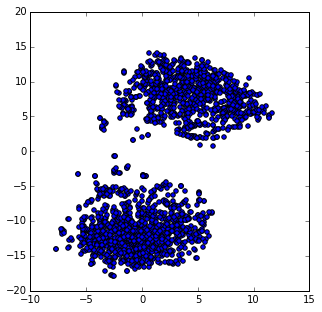

In [140]:
#find the t-sne embedding using the distance metric
reload(csi)
np.random.seed(1234)
embedding_corr = csi.getTsneEmbeddingOfGrammars(seqlets_corr_mat, perplexity=50, verbose=2)
mplh.scatterPlot(embedding_corr)

In [141]:
import sklearn.cluster
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=2, n_init=10).fit_predict(embedding_corr)

No colors supplied, so autogen'd as:
(0, [0.0, 1.0, 0.0])
(1, [0.0, 0.0, 1.0])


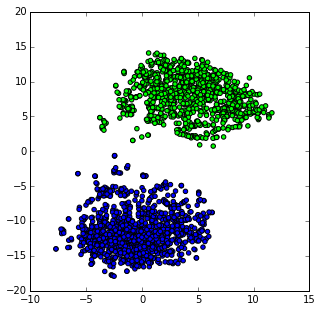

In [142]:
mplh.scatterPlot(embedding_corr, labels=kmeans_clusters)

In [144]:
merged_motifs = csi.createMergedGrammars(kmeans_clusters, seqlets
                                          , subtracksToInclude=["sequence_multipliers"]
                                          , accountForRevComp=True)
trimming_func = csi.TrimArrayColumnsToNumUnderlyingObs(0.5)
merged_motifs = csi.adjustGrammarsUsingTrimmingCriterion(merged_motifs,trimmingFunc=trimming_func)

('fwd motif', 0)


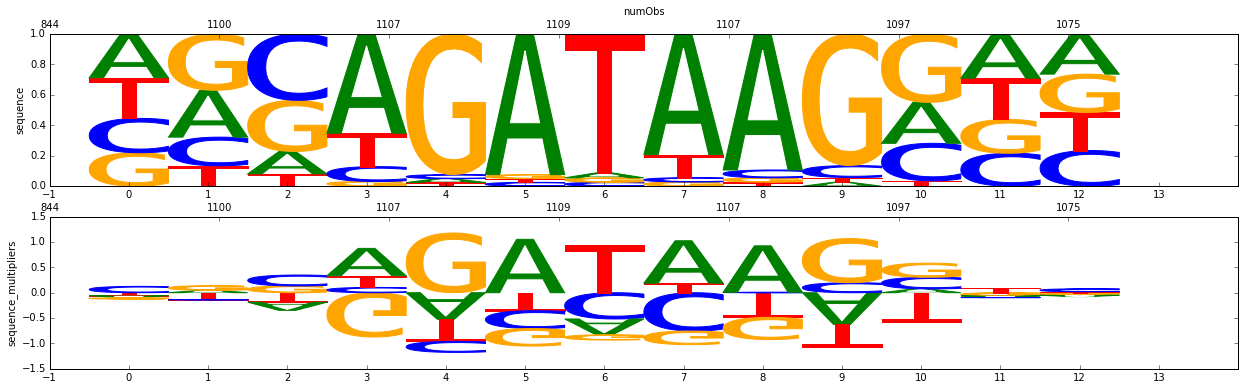

('rev motif', 0)


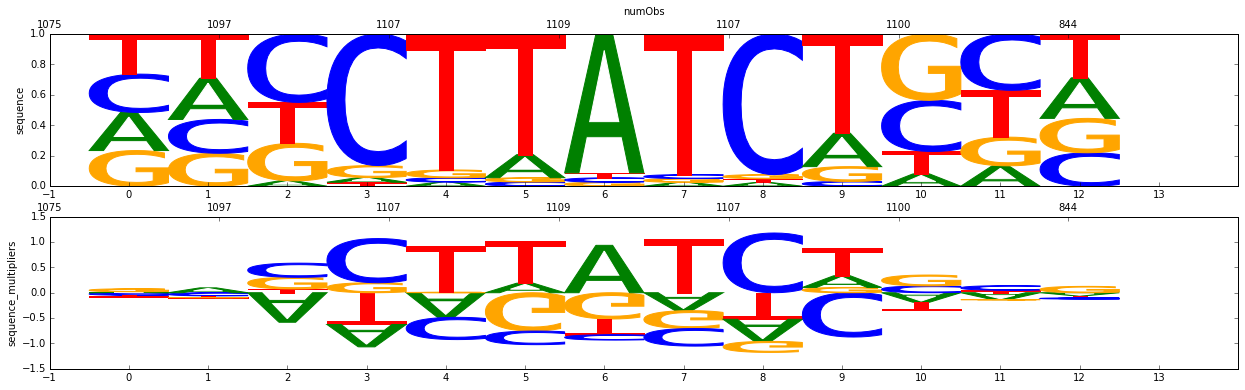

('fwd motif', 1)


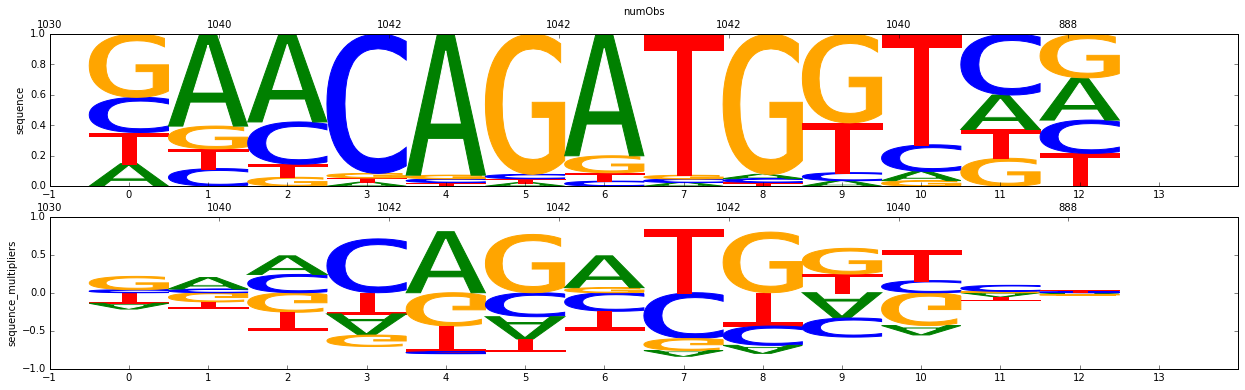

('rev motif', 1)


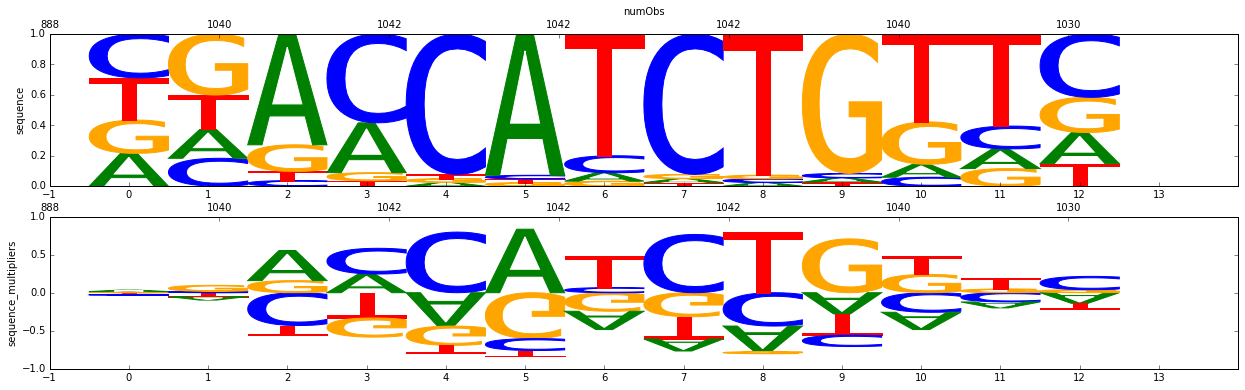

In [145]:
for idx, motif  in enumerate(sorted(merged_motifs.values(), key=lambda x: -x.totalObservationsEver)):
    print("fwd motif",idx)
    csi.printGrammar(motif, trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])
    print("rev motif",idx)
    csi.printGrammar(motif.getRevCompGrammar(), trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])